# Supervised Music Classifications with CNN 
## 0. Introduction
### 0.1 Task
~ explain task to be solved

### 0.2 Related Work
~ show related work from literature / internet 

## 1. Data Loading and Visualisation

In [1]:
import os
# check current working directory if necessary... 
print(os.getcwd())

/Users/nicolasvogel/Dokumente/16_ZHAW_MSc/V5_6_NeuralNetworks&DeepLearning/NNDL_Project_Repo


### 1. 1 Set random seed

In [2]:
import torch
import numpy as np
import random

# Set seed for PyTorch
torch.manual_seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's random module
random.seed(42)

# If you are using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### 1.2 Load images and safe them in to an image list

In [3]:
import os
from PIL import Image

input_dir = "./images_original/blues"

# load images one after another - useful for images one by one
for image in os.listdir(input_dir):
    img = Image.open(os.path.join(input_dir, image))
    # do whatever you like to do with the img

# load all images data at in to list
image_list = [Image.open(os.path.join(input_dir, image)) for image in os.listdir(input_dir)]


### 1.3 Print first images to get an idea of the data

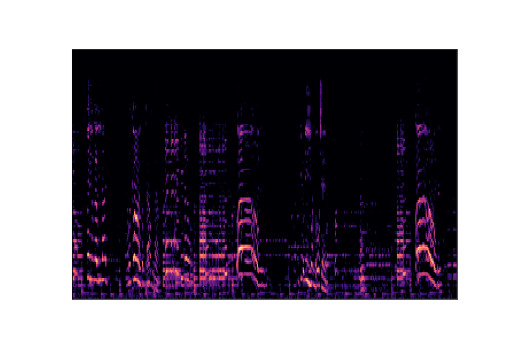

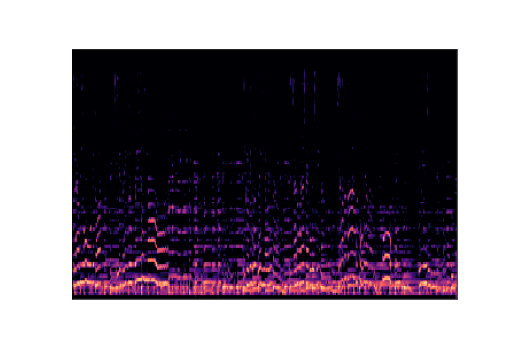

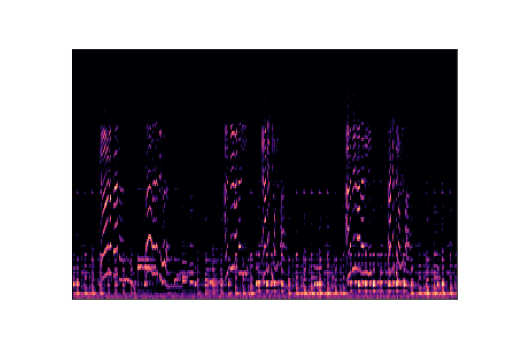

In [4]:
import matplotlib.pyplot as plt

# Print first 3 images in the list
counter = 0
for img in image_list:
    if counter < 3: 
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
        counter += 1
    else: 
        break

### 1.4 Data explanation
~ explain insights from visualizing and analysis

## 2 Data Preprocessing
#### 2.1 Load Data, Subseting 
Load data into tensors and create subset, 

Split the datafolder into test and training data (not equal across genres yet!) -> unbalanced

In [5]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import collections

In [6]:
# Data directory
data_dir = "./images_original"

# Load full the dataset with original image size
dataset = ImageFolder(data_dir, transform=transforms.Compose([transforms.Resize((288, 432)), # Adjust to original image size  ---------------------  WHY?? 
transforms.ToTensor()]))

# Load the dataset with resized images
# dataset = ImageFolder(data_dir, transform=transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.ToTensor()]))

# Load a subset of the dataset*
# criterion for subset, and  initialization
class_counts = collections.defaultdict(int)
max_per_class = 20  # maximum number of spectrograms per genre
genre_indices = []

# Iterate through the dataset and select indices of spectrogram's*
for idx, (img, label) in enumerate(dataset):
    if class_counts[label] < max_per_class:
        genre_indices.append(idx)
        class_counts[label] += 1
    # stopping criteria if all genres contain 10 spectrogram's
    if len(class_counts) == len(dataset.classes) and all(c >= max_per_class for c in class_counts.values()):
        break

# created subset with the selected indices*
subset = Subset(dataset, genre_indices)

# check length of subset *
print(f"Spectrogram's in subset: {len(subset)}")


Spectrogram's in subset: 200


### 2.2 Train Test Split
Split the dataset into training and testing sets

In [7]:
# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

#==============  Train Test split for whole dataset ============== #
# # Calculate the number of samples for training and testing
# train_size = int(train_ratio * len(dataset))
# test_size = len(dataset) - train_size
# 
# # Randomly split the dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# 
# # Create data loaders (load the train and validation into batches)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 
# # Print the number of samples in each set
# print(f"Number of training samples: {len(train_dataset)}") # one sample from the genre jazz is missing --> only 999 instead of 1000 samples
# print(f"Number of testing samples: {len(test_dataset)}")
# print(train_dataset)

Train-test split for the subset is done differently such as the data has to be stratified (equal across genres).

In [8]:
#==============  Train Test split for sub dataset ============== #
from sklearn.model_selection import train_test_split

# Collect indices and labels
all_indices = list(range(len(subset)))
all_labels = [subset[i][1] for i in all_indices]  # Integer-Labels

# Stratified Split
train_indices, test_indices = train_test_split(
    all_indices,
    train_size=train_ratio,
    stratify=all_labels,
    random_state=42  # for reproducibility
)

# create subsets
train_subset = Subset(subset, train_indices)
test_subset = Subset(subset, test_indices)

# Create data loaders (load the train and validation into batches)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Print the number of samples in each set
print(f"Number of training samples: {len(train_subset)}") 
print(f"Number of testing samples: {len(test_subset)}")


Number of training samples: 160
Number of testing samples: 40


check if train-test split is stratified (equal across genres)

In [9]:
from collections import Counter

# helper function to get distribution of classes
def get_dist(ds):
    return Counter([ds[i][1] for i in range(len(ds))])

# print distributions
print("Train:", get_dist(train_subset))
print("Test:", get_dist(test_subset))

Train: Counter({8: 16, 6: 16, 5: 16, 0: 16, 3: 16, 2: 16, 9: 16, 7: 16, 1: 16, 4: 16})
Test: Counter({1: 4, 2: 4, 5: 4, 6: 4, 9: 4, 3: 4, 8: 4, 7: 4, 4: 4, 0: 4})


### 2.3 Visualize some samples
Look at first 3 images of training dataset (function proposed by microsoft copilot)


Genre : indices mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


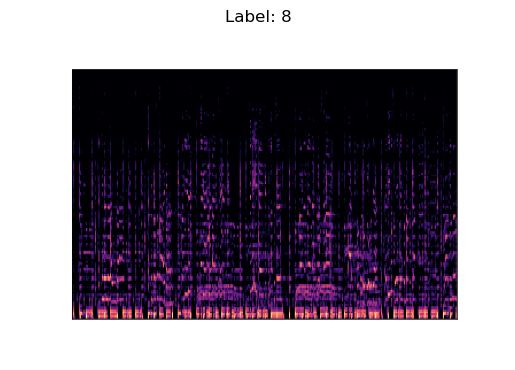

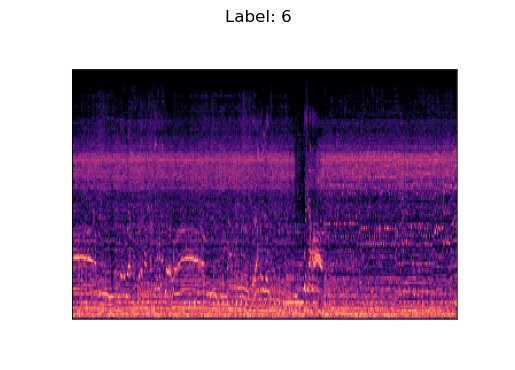

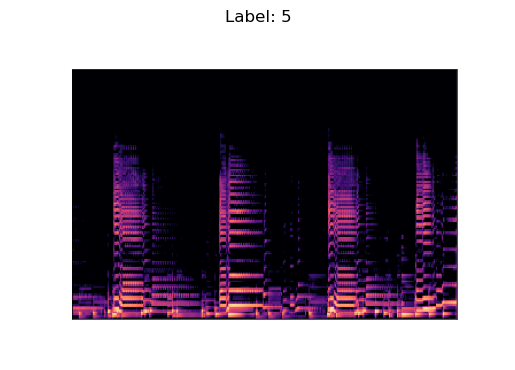

In [10]:
# Function to show an image
def show_image(img, title=None):
    img = img.permute(1, 2, 0)  # Change the order of dimensions
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# print indices of the genres
print("Genre : indices mapping:", dataset.class_to_idx)

# Display a few images from the training dataset
for i in range(3):  # Change the range to display more or fewer images
    img, label = train_subset[i]
    show_image(img, title=f"Label: {train_subset.dataset.indices[label]}")
    

#### Visualize training batch (batch size 32 see above)

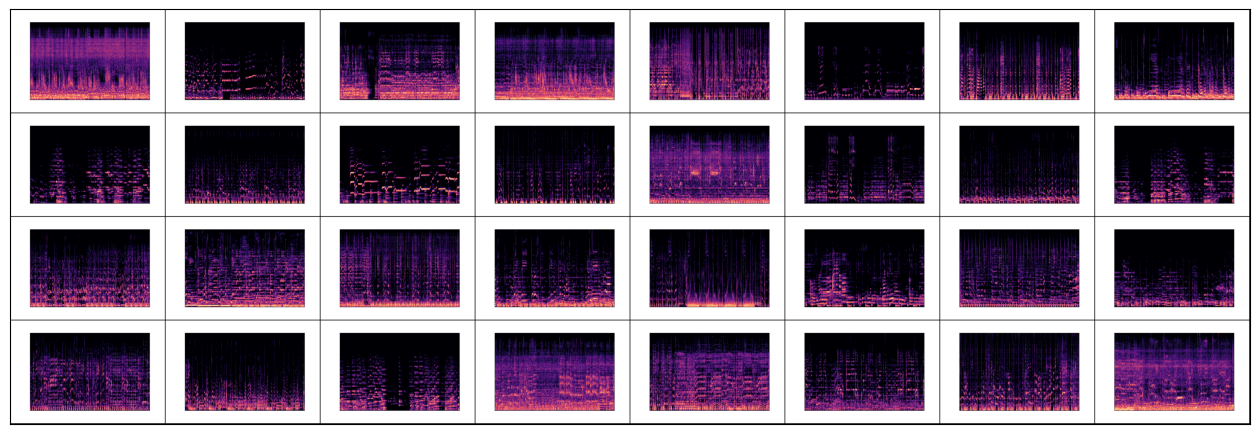

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

show_batch(train_loader)

### 2.4 Recall tensor shapes of dataset and subset

In [12]:
img, label = dataset[0]
print("Tensor shape (dataset):",  img.shape, "Genre:", label)
img, label = train_subset[0]
print("Tensor shape (subset):", img.shape, "Genre:", label) # prints size of first image: 3 channels (RGB), height, width
# show_image(img, title=f"Label: {train_subset.dataset.indices[label]}")

#output :
#torch.Size([3, 288, 432])  
#torch.Size([3, 288, 432])

Tensor shape (dataset): torch.Size([3, 288, 432]) Genre: 0
Tensor shape (subset): torch.Size([3, 288, 432]) Genre: 8


## 3 Model Development
### 3.1 Base Model for Image Classification
This base class is used to develop all neural networks. We add functionalities to the base to train the model, 

validate the model and get the result for each epoch. It's reusable and can be used for any image classification model, 

no need to rewrite this every time.

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'],result['val_loss'], result['val_acc']))

Concepts to refine the model: Convolution, Padding, Stride, Maxpooling

### 3.2 CNN Model Architecture 
Final model with 3 CNN blocks, each consisting of 2 convolutional layers & 1 max-pooling layer. 

Relu activation function is used to remove negative values from the feature map. 

Stride(1, 1), padding = 1. After applying convolution and feature extracting a flatten layer is used to flatten the tensor from 3 to 1 dimension. 

Then 3 linear layers are added to reduce the size of the tensor and learn the features.

In [14]:

class CNN_dynamic(ImageClassificationBase):
    def __init__(self, conv_configs, linear_sizes):
        """
        conv_configs: list of tuples -> [(out_channels, kernel_size, padding), ...]
        linear_sizes: list with numbers of neurons for each fc layer -> [input_size, hidden1, hidden2, ..., output_size]
        """
        super().__init__()
        self.conv_layers = nn.ModuleList()
        input_channels = 3 # the input pictures have only one channel
        for output_channels, kernel_size, padding, use_pool in conv_configs:
            self.conv_layers.append(nn.Conv2d(input_channels, output_channels, kernel_size, padding = padding))
            self.conv_layers.append(nn.ReLU())
            if use_pool: # functionality to avoid pooling at the end of a layer
                self.conv_layers.append(nn.MaxPool2d(2, 2))
            input_channels = output_channels # reasing the input channel to the output channels of the previous layer
            
        self.flatten = nn.Flatten()
        
        self.linear_layers = nn.ModuleList()
        for i in range(len(linear_sizes) -1):
            self.linear_layers.append(nn.Linear(linear_sizes[i], linear_sizes[i+1]))
            if i < len(linear_sizes) - 2:
                self.linear_layers.append(nn.ReLU())
            
        self.linear_layers.append(nn.Softmax(dim = 1))
    
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        for layer in self.linear_layers:
            x = layer(x)
        return x
                

### 3.3 Hyperparameters, Model Training, And Evaluation:
Now we have to train the music genre classification model on the training dataset. That defines the fit, evaluation and accuracy methods.

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
# Instantiate the model
# initialize conv layers
conv_configs = [(32, 3, 'same', False), (32, 3, 'same', True), 
                            (64, 3, 'same', False), (64, 3, 'same', True), 
                            (128, 3, 'same', False), (128, 3, 'same', False), (128, 3, 'same', False), (128, 3, 'same', True) ]
linear_sizes = [248832, 62208, 4096, 1024, 128, 10]

model = CNN_dynamic(conv_configs, linear_sizes)

# Number of epochs
num_epochs = 5

# Optimizer
opt_func = torch.optim.Adam

# Learning rate
lr = 0.001

# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func) # in online article they used val_loader (validation) instead of test_loader

In [67]:
# # Check the number of classes in the dataset
# num_classes = len(dataset.classes)
# print(f"Number of classes: {num_classes}")
# 
# for hist in history: 
#     print(hist['train_loss'])
#     
# plt.plot([h['val_loss'] for h in history], label='Validation Loss')
# # plt.plot([h['val_acc'] for h in history], label='Validation Accuracy')
# plt.plot([h['train_loss'] for h in history], label='Train Loss')
# plt.legend()
# plt.show()

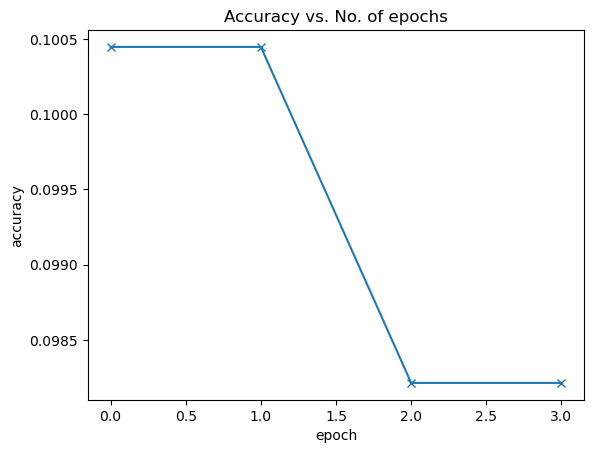

In [49]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

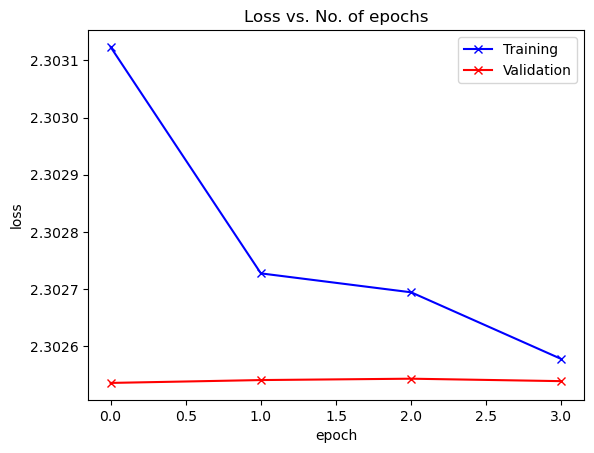

In [50]:

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)